# Combine Spotify and Bugs Data

In [1]:
import pandas as pd

# Load the CSV files into DataFrames
df1 = pd.read_csv('spotify_data_10000.csv')
df2 = pd.read_csv('spotify_track_data_bugs.csv')

# Combine them by stacking the rows
df = pd.concat([df1, df2], ignore_index=True)

# Data Cleaning

### #1 Check and Handle Missing Values

In [2]:
missing_values = df.isnull().sum()
missing_values

track_name              1
track_id                0
album_name              0
album_id                0
artist_name             0
artist_id               0
artist_popularity     386
track_popularity        0
release_date            0
genres               3438
danceability           10
energy                 10
key                    10
loudness               10
mode                   10
speechiness            10
acousticness           10
instrumentalness       10
liveness               10
valence                10
tempo                  10
duration_ms            10
dtype: int64

In [3]:
# genres column 제거
df = df.drop(columns=['genres'])

# Remove the single missing value for track_name and rows with missing audio features (small number of rows)
df = df.dropna(subset=['track_name', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'])

# Remove 386 missing values for artist_popularity
df = df.dropna(subset=['artist_popularity'])

# 중간 점검
df.shape, df.describe()

((29097, 21),
        artist_popularity  track_popularity  danceability        energy  \
 count       29097.000000      29097.000000  29097.000000  29097.000000   
 mean           47.422965         21.044060      0.574473      0.603637   
 std            23.517216         19.908872      0.174068      0.243830   
 min             0.000000          0.000000      0.000000      0.000126   
 25%            33.000000          3.000000      0.462000      0.436000   
 50%            47.000000         17.000000      0.595000      0.644000   
 75%            63.000000         33.000000      0.704000      0.805000   
 max           100.000000         98.000000      0.988000      1.000000   
 
                 key      loudness          mode   speechiness  acousticness  \
 count  29097.000000  29097.000000  29097.000000  29097.000000  29097.000000   
 mean       5.208028     -7.804188      0.634052      0.083641      0.345687   
 std        3.554893      5.115512      0.481703      0.099443      0

### #2 Convert release_date to datetime

In [4]:
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d', errors='coerce')
df['release_date'].head()

0          NaT
1   2005-01-01
2   2009-01-08
3   2007-01-01
4   2014-02-21
Name: release_date, dtype: datetime64[ns]

In [5]:
NaT_rows = df[df['release_date'].isna()]
print(NaT_rows[['track_name', 'release_date']].head())
len(NaT_rows)

                                           track_name release_date
0                                      Precious Peace          NaT
9   Strauss Jr., J.: An der schönen blauen Donau, ...          NaT
11                                  Bye Bye Blackbird          NaT
20                                  Call Me a Warrior          NaT
40             Mudbone Goes To Hollywood - Remastered          NaT


1420

### #3 Data Visualizations

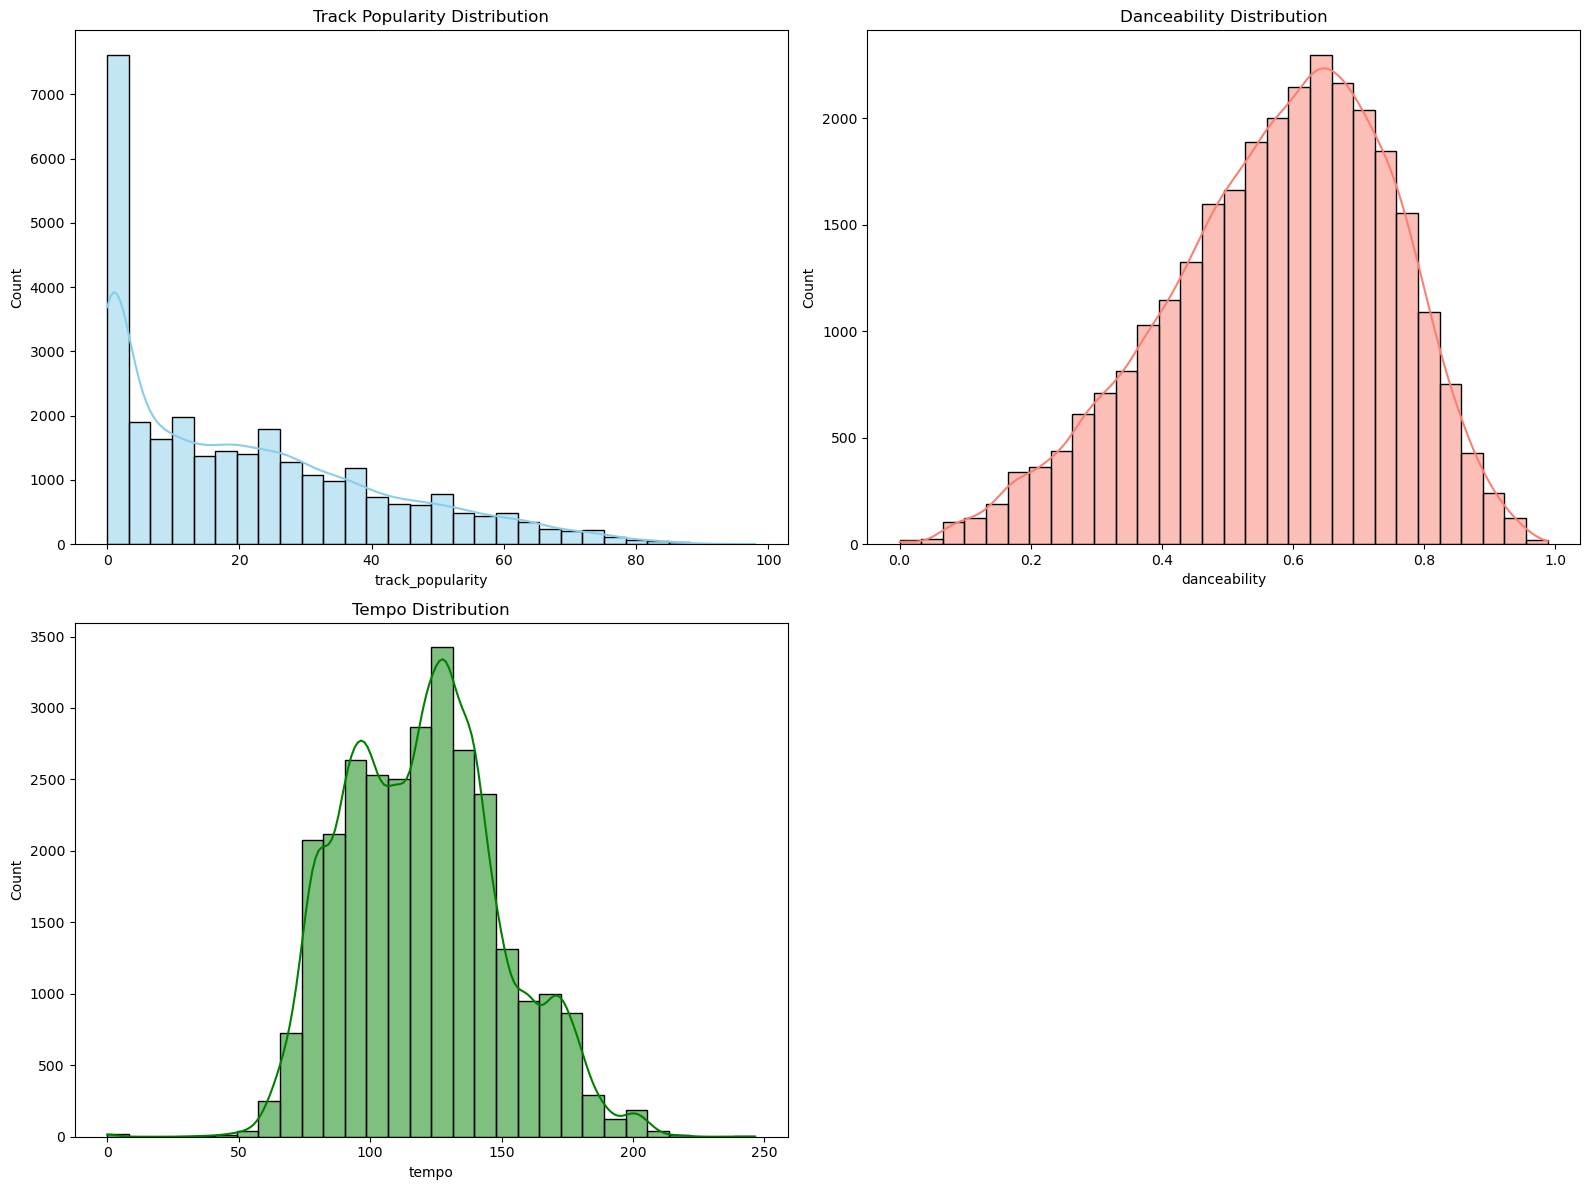

In [6]:
# Data Vis for continuous variables --> track_popularity, danceability, tempo

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure size for the plots
plt.figure(figsize=(16, 12))

# Histogram for track popularity
plt.subplot(2, 2, 1)
sns.histplot(df['track_popularity'], bins=30, kde=True, color='skyblue')
plt.title('Track Popularity Distribution')

# Histogram for danceability
plt.subplot(2, 2, 2)
sns.histplot(df['danceability'], bins=30, kde=True, color='salmon')
plt.title('Danceability Distribution')

# Histogram for tempo
plt.subplot(2, 2, 3)
sns.histplot(df['tempo'], bins=30, kde=True, color='green')
plt.title('Tempo Distribution')

# Show the plots
plt.tight_layout()
plt.show()

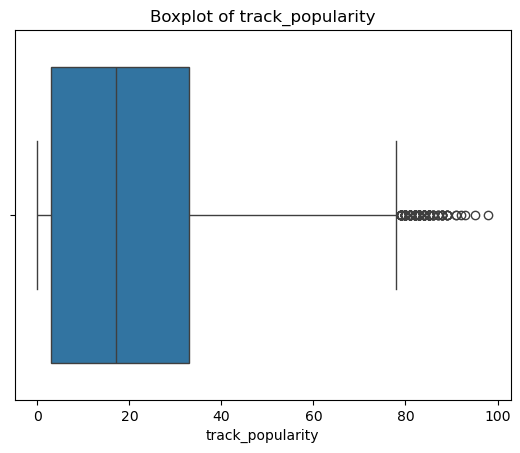

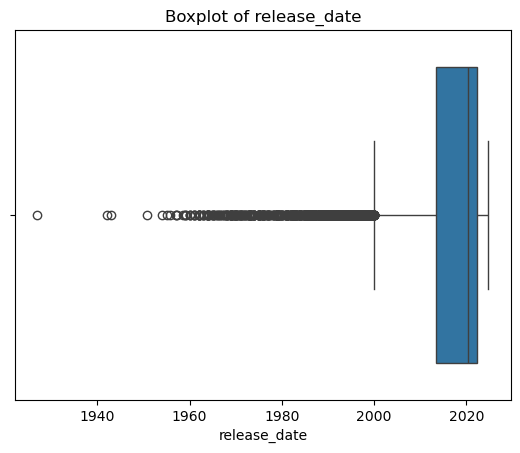

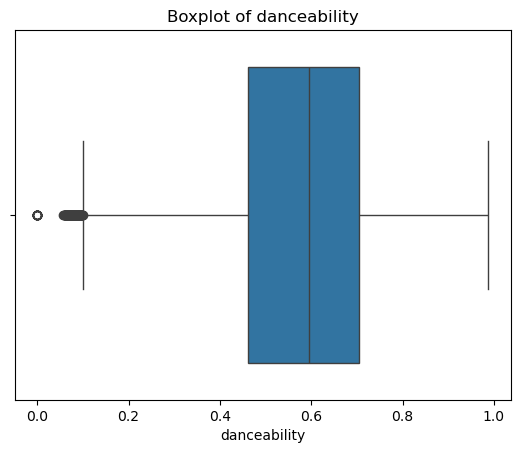

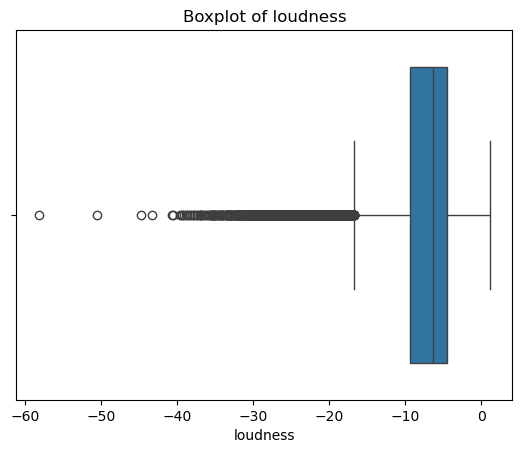

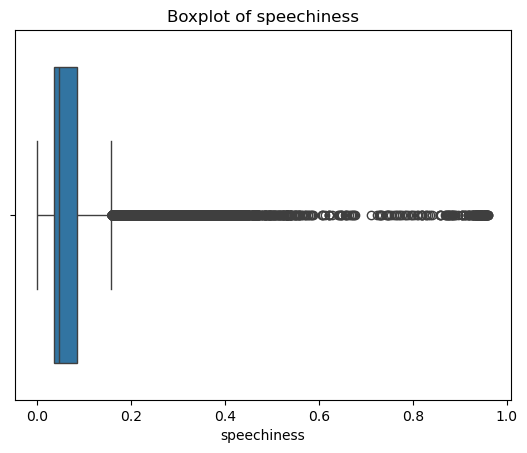

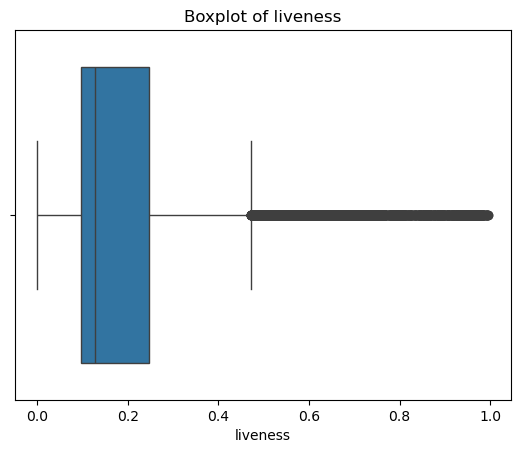

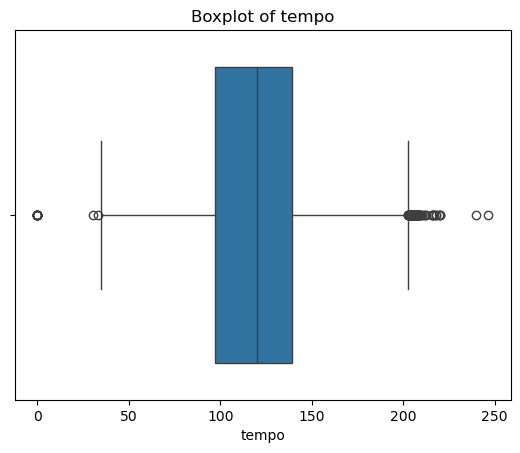

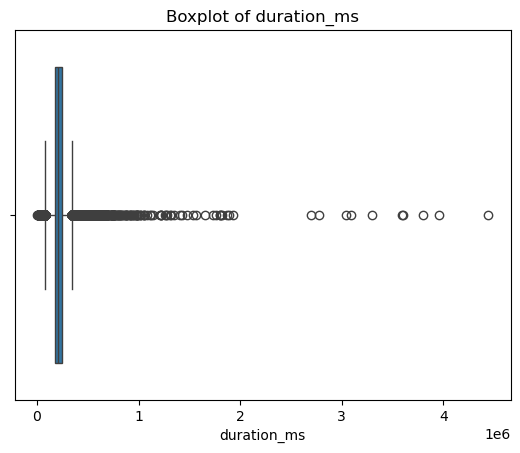

In [7]:
# Data Vis for to identify outliers

# Boxplot for track_popularity
sns.boxplot(x='track_popularity', data=df)
plt.title('Boxplot of track_popularity')
plt.show()

# Boxplot for release_date
sns.boxplot(x='release_date', data=df)
plt.title('Boxplot of release_date')
plt.show()

# Boxplot for danceability
sns.boxplot(x='danceability', data=df)
plt.title('Boxplot of danceability')
plt.show()

# Boxplot for loudness
sns.boxplot(x='loudness', data=df)
plt.title('Boxplot of loudness')
plt.show()

# Boxplot for speechiness
sns.boxplot(x='speechiness', data=df)
plt.title('Boxplot of speechiness')
plt.show()

# Boxplot for liveness
sns.boxplot(x='liveness', data=df)
plt.title('Boxplot of liveness')
plt.show()

# Boxplot for tempo
sns.boxplot(x='tempo', data=df)
plt.title('Boxplot of tempo')
plt.show()

# Boxplot for duration_ms
sns.boxplot(x='duration_ms', data=df)
plt.title('Boxplot of duration_ms')
plt.show()

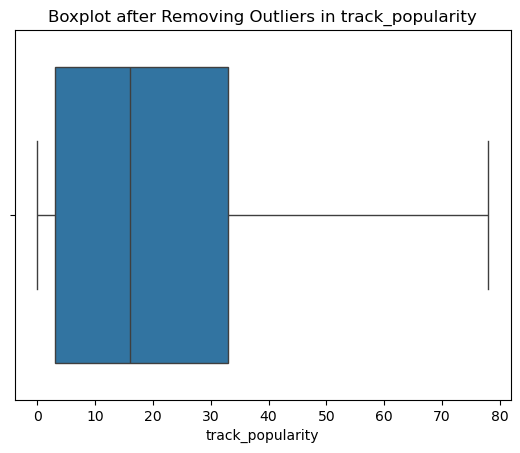

In [8]:
# We will consider track_popularity data over the max as an outlier --> remove such outliers

import pandas as pd

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['track_popularity'].quantile(0.25)
Q3 = df['track_popularity'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Calculate the upper bound (whisker)
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove rows with values beyond the upper bound
df = df[df['track_popularity'] <= upper_bound]

# Data Vis after removing outliers in track_popularity
sns.boxplot(x='track_popularity', data=df)
plt.title('Boxplot after Removing Outliers in track_popularity')
plt.show()


### #4 K-Means Test

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score

# Step 1: Select relevant numerical features for clustering
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# Drop rows with missing values in the selected features
df_clustering = df[numerical_features].dropna()

# Step 2: Standardize the numerical features for better clustering performance
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # You can choose the number of clusters (n_clusters)
cluster_labels = kmeans.fit_predict(df_scaled)

# Calculate Silhouette Score --> higher, the better
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
print(f'Silhouette Coefficient: {silhouette_avg}')

# Calculate the Calinski-Harabasz Index --> higher, the better
calinski_harabasz = calinski_harabasz_score(df_scaled, cluster_labels)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')

c:\Users\sduss\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\sduss\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Silhouette Coefficient: 0.1895539923881568
Calinski-Harabasz Index: 4819.817823511415


# Create (Hopefully!) Meaningful Derived Variables

### #1 Track Age (in years)

In [10]:
# Older tracks might have different user appeal compared to newer releases.
# Formula: Current year minus release_date.

from datetime import datetime

# Assuming 'release_date' is already converted to datetime format
df['track_age'] = datetime.now().year - df['release_date'].dt.year

In [11]:
# Step 1: Select relevant numerical features for clustering
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_age']

# Drop rows with missing values in the selected features
df_clustering = df[numerical_features].dropna()

# Step 2: Standardize the numerical features for better clustering performance
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # You can choose the number of clusters (n_clusters)
cluster_labels = kmeans.fit_predict(df_scaled)

# Calculate Silhouette Score --> higher, the better
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
print(f'Silhouette Coefficient: {silhouette_avg}')

# Calculate Calinski-Harabasz Index --> higher, the better
calinski_harabasz = calinski_harabasz_score(df_scaled, cluster_labels)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')

Silhouette Coefficient: 0.15866400344903145
Calinski-Harabasz Index: 4001.1010971680093


In [12]:
# Adding track_age as a derived variable leads to worse Silhouette Coefficient and Calinski-Harabasz Index.
# Remove track_age column.
df = df.drop(columns=['track_age'])

### #2 Track and Artist Popularity Ratio

In [13]:
# A derived variable showing the relative popularity of a track compared to the artist's overall popularity.
# Formula: track_popularity / artist_popularity.
df['popularity_ratio'] = df['track_popularity'] / df['artist_popularity']


# Error: Input X contains infinity or a value too large for dtype('float64')
# Error Resolution:
# Step 1: Ensure popularity_ratio is of type float64
df['popularity_ratio'] = df['popularity_ratio'].astype('float64')
# Step 2: Truncate the values to be less than 1.0 (or any threshold you prefer)
df['popularity_ratio'] = df['popularity_ratio'].apply(lambda x: min(x, 1.0))
# Display first few rows to confirm
print(df[['track_name', 'popularity_ratio']].head())


                                          track_name  popularity_ratio
0                                     Precious Peace          0.264706
1  Keyboard Sonata in E Minor, Wq. 49/3, H. 33, "...          0.016949
2                                   Around The World          0.961538
3                         Gadget - Gak Sato 99' Edit          0.000000
4                                        Crucem Tuam          0.000000


In [14]:
# Step 1: Select relevant numerical features for clustering
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'popularity_ratio']

# Drop rows with missing values in the selected features
df_clustering = df[numerical_features].dropna()

# Step 2: Standardize the numerical features for better clustering performance
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # You can choose the number of clusters (n_clusters)
cluster_labels = kmeans.fit_predict(df_scaled)

# Calculate Silhouette Score --> higher, the better
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
print(f'Silhouette Coefficient: {silhouette_avg}')

# Calculate Calinski-Harabasz Index --> higher, the better
calinski_harabasz = calinski_harabasz_score(df_scaled, cluster_labels)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')

Silhouette Coefficient: 0.15430177114040342
Calinski-Harabasz Index: 3874.3289252585696


In [15]:
# Adding popularity_ratio as a derived variable leads to worse Silhouette Coefficient and Calinski-Harabasz Index.
# Remove popularity_ratio column.
df = df.drop(columns=['popularity_ratio'])

### #3 Energy-Danceability Interaction

In [16]:
# High-energy tracks with high danceability may suggest lively, danceable songs.
# Formula: Multiply energy by danceability.
df['energy_danceability'] = df['energy'] * df['danceability']

In [17]:
# Step 1: Select relevant numerical features for clustering
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'energy_danceability']

# Drop rows with missing values in the selected features
df_clustering = df[numerical_features].dropna()

# Step 2: Standardize the numerical features for better clustering performance
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # You can choose the number of clusters (n_clusters)
cluster_labels = kmeans.fit_predict(df_scaled)

# Calculate Silhouette Score --> higher, the better
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
print(f'Silhouette Coefficient: {silhouette_avg}')

# Calculate Calinski-Harabasz Index --> higher, the better
calinski_harabasz = calinski_harabasz_score(df_scaled, cluster_labels)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')


# Silhouette Coefficient decreased by 0.03, but Calinski-Harabasz Index increased by 500.
# Our new derived variable 'energy_danceability' seems meaningful, so we will keep it.

Silhouette Coefficient: 0.209548427265281
Calinski-Harabasz Index: 5149.99406719737


### #4 Acousticness vs Instrumentalness

In [18]:
# Tracks with high acousticness but low instrumentalness might suggest acoustic but vocal-heavy tracks.
# Formula: Subtract instrumentalness from acousticness.
df['acoustic_instrumental_diff'] = df['acousticness'] - df['instrumentalness']

In [19]:
# Step 1: Select relevant numerical features for clustering
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'energy_danceability', 'acoustic_instrumental_diff']

# Drop rows with missing values in the selected features
df_clustering = df[numerical_features].dropna()

# Step 2: Standardize the numerical features for better clustering performance
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # You can choose the number of clusters (n_clusters)
cluster_labels = kmeans.fit_predict(df_scaled)

# Calculate Silhouette Score --> higher, the better
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
print(f'Silhouette Coefficient: {silhouette_avg}')

# Calculate Calinski-Harabasz Index --> higher, the better
calinski_harabasz = calinski_harabasz_score(df_scaled, cluster_labels)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')


# Silhouette Coefficient increased by 0.07, and Calinski-Harabasz Index increased by 480.
# Our new derived variable 'acoustic_instrumental_diff' seems VERY meaningful, so we will keep it.

Silhouette Coefficient: 0.22054932841877672
Calinski-Harabasz Index: 5733.699137121231


### #5 Mood Index

In [20]:
# Combine features related to the "mood" of a track, such as valence (positivity) and energy, to create an overall mood index.
# Formula: Average of valence and energy.
df['mood_index'] = (df['valence'] + df['energy']) / 2

In [21]:
# Step 1: Select relevant numerical features for clustering
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'energy_danceability', 'acoustic_instrumental_diff', 'mood_index']

# Drop rows with missing values in the selected features
df_clustering = df[numerical_features].dropna()

# Step 2: Standardize the numerical features for better clustering performance
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # You can choose the number of clusters (n_clusters)
cluster_labels = kmeans.fit_predict(df_scaled)

# Calculate Silhouette Score --> higher, the better
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
print(f'Silhouette Coefficient: {silhouette_avg}')

# Calculate Calinski-Harabasz Index --> higher, the better
calinski_harabasz = calinski_harabasz_score(df_scaled, cluster_labels)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')


# Silhouette Coefficient decreased by 0.06, and Calinski-Harabasz Index increased by 400.
# Our new derived variable 'mood_index' seems meaningful, so we will keep it.

Silhouette Coefficient: 0.24619060177953034
Calinski-Harabasz Index: 6109.115475947917


# Save the Final Dataset

In [22]:
df.to_csv('final_dataset.csv', index=False)